# Time series modeling: Random Forest and Gradient Boosting

Notebook to add time series variables to models using pyspark. Based on [this blog post](https://medium.com/analytics-vidhya/time-series-forecasting-using-spark-ml-part-2-31506514c643)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)
%cd gdrive/MyDrive/Colab\ Notebooks/Big_Data

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/Big_Data


In [3]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, LongType

import statsmodels.tsa.stattools as ts

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# start session
spark = SparkSession.builder.master("local[5]").appName("groupbyagg").getOrCreate()

# Data

In [6]:
data = spark.read.csv('Sunspots.csv',inferSchema=True,header=True)

In [7]:
data = data.withColumnRenamed('Monthly Mean Total Sunspot Number', 'sunspots')
data = data.select(to_date(col("date"),"yyyy-mm-dd").alias("date"), 'sunspots')
data.show(1)

+----------+--------+
|      date|sunspots|
+----------+--------+
|1749-01-31|    96.7|
+----------+--------+
only showing top 1 row



In [8]:
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- sunspots: double (nullable = true)



# Create Variables

Before running the next code, set the following variables:
* n_lags: the number of previous months to lag with
* data_lag: a new dataframe to put lagged variables in
* features: a list of the features created (for use in vectorassembler later)
* forecast_months: number of time-steps to forecast (for example, we could say 10 and get the predicted average sunspots for the next 10 months)

In [9]:
n_lags = 5
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

## Create lags

Create the time-lagged mean sunspot values

In [10]:
# add col to partition by
data_lag = data_lag.withColumn("Series",lit('Univariate'))

# set up window
lag_window = Window.orderBy("Series")

for i in range(n_lags):
    str_lag = 'sunspots'+'_lag_'+str(i+1)
    data_lag = data_lag.withColumn(str_lag,
                                   lag(data_lag['sunspots'], i+1).over(lag_window))
    features.append(str_lag)
    
data_lag = data_lag.drop('Series')    
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|
|1749-01-31|   116.7|         104.3|          96.7|          null|          null|          null|
|1749-01-30|    92.8|         116.7|         104.3|          96.7|          null|          null|
|1749-01-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
only showing top 5 rows



## Moving average over lag window

In [11]:
mavg_window = Window.rowsBetween(-n_lags, 0)
str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
data_lag = data_lag.withColumn(str_mov_avg, avg(data_lag['sunspots']).over(mavg_window))
features.append(str_mov_avg)
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|
|1749-01-31|   116.7|         104.3|          96.7|          null|          null|          null|   105.89999999999999|
|1749-01-30|    92.8|         116.7|         104.3|          96.7|          null|          null|              102.625|
|1749-01-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|   110.44000000000001|
+----------+--------+--------------+------------

## Time Series Trends

How do sunspots change from one month to the next? Use this sign variable to find out

In [12]:
# if current sunspots > time-lagged sunspots then sign = +1.0
# if current sunspots < time-lagged sunspots then sign = -1.0
data_lag = data_lag.withColumn("Series",lit('Univariate'))       
trend_window = Window.orderBy("Series")
for i in range(n_lags):
    str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
    data_lag = data_lag.withColumn(str_sign,\
                        signum((data_lag['sunspots'] - lag(data_lag['sunspots'],i+1).over(trend_window))))
    features.append(str_sign)

data_lag = data_lag.drop("Series")

data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|sunspots_lag_1_sign|sunspots_lag_2_sign|sunspots_lag_3_sign|sunspots_lag_4_sign|sunspots_lag_5_sign|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|               null|               null|               null|               null|               null|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|      

## Put all above data manipulations into one function

In [13]:
def create_ts_vars(data, n_lags, features):

  ## LAG VARS ######################################################################
  # add col to partition by
  data = data.withColumn("Series",lit('Univariate'))

  # set up window
  lag_window = Window.orderBy("Series")

  for i in range(n_lags):
      str_lag = 'sunspots'+'_lag_'+str(i+1)
      data = data.withColumn(str_lag, lag(data['sunspots'], i+1).over(lag_window))
      features.append(str_lag)
      
  data = data.drop('Series')   

  ## MOVING AVG VAR ##############################################################
  mavg_window = Window.rowsBetween(-n_lags, 0)
  str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
  data = data.withColumn(str_mov_avg, avg(data['sunspots']).over(mavg_window))
  features.append(str_mov_avg)

  ## TREND VAR ###################################################################
  # if current sunspots > time-lagged sunspots then sign = +1.0
  # if current sunspots < time-lagged sunspots then sign = -1.0
  data = data.withColumn("Series",lit('Univariate'))       
  trend_window = Window.orderBy("Series")
  for i in range(n_lags):
      str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
      data = data.withColumn(str_sign,\
                          signum((data['sunspots'] - lag(data['sunspots'],i+1).over(trend_window))))
      features.append(str_sign)
      
  data = data.drop("Series")
  
  return(data)

## Train/Test Split

In [14]:
def split_time_series(data, train_ratio=0.7):
     
    # split data into train and test but maintain time-order
    newSchema  = StructType(data.schema.fields + \
                [StructField('Row Number', LongType(), False)])
    new_rdd = data.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])

    # create new df with row number
    new_df = spark.createDataFrame(new_rdd, newSchema)
    total_rows = new_df.count()
    splitFraction  =int(total_rows*train_ratio)

    df_train = new_df.where(new_df['Row Number'] >= 0)\
                   .where(new_df['Row Number'] <= splitFraction)
    df_test = new_df.where(new_df['Row Number'] > splitFraction)
    
    return df_train, df_test

## Set up data for modeling

In [15]:
def data_for_modeling(data, forecast_months):
  # create label 
  lead_window = Window.rowsBetween(0,forecast_months)   
  data = data.withColumn("label", last(data['sunspots']).over(lead_window))
  
  # vector assembler
  data = data.dropna()
  assembler = VectorAssembler().setInputCols(features).setOutputCol("features")
  data_transformed = assembler.transform(data)

  return(data_transformed)

# Helper Functions

## Check that distribution is stationary 

In [16]:
def CheckStationarity(timeSeriesCol):
    
    # this function works with Pandas dataframe only not with spark dataframes
    # this performs Augmented Dickey-Fuller's test
    
    test_result = ts.adfuller(timeSeriesCol.values)
    print('ADF Statistic : %f \n' %test_result[0])
    print('p-value : %f \n' %test_result[1])
    print('Critical values are: \n')
    print(test_result[4])

## Prediction

In [17]:
def Predict(I, df1, df2, timeSeriesCol, predictionCol, joinCol):
    
    # converts differenced predictions to raw predictions
    dZCol = 'DeltaZ'+str(i) 
    f_strCol = 'forecast_'+str(i)+'day'
    df = df1.join(df2, [joinCol], how='inner').orderBy(asc('Date'))
    df = df.withColumnRenamed(predictionCol, dZCol)
    df = df.withColumn(f_strCol, col(dZCol)+col(timeSeriesCol))

    return df

## Save results for comparison

# Data for Modeling

1. Run create_ts_vars using desired variables

In [38]:
n_lags = 12*3
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

In [39]:
data_lag = create_ts_vars(data_lag, n_lags, features)
data_lag.show(10)

+----------+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------

In [40]:
len(data_lag.columns)-1

74

2. Set up data for modeling (set up label, [features])

In [41]:
data_transformed = data_for_modeling(data_lag, forecast_months)

3. Train-test split

In [42]:
train, test = split_time_series(data_transformed, 0.7)

In [43]:
print(train.count())
print(test.count())

2261
968


Now the data is ready for modeling! 

# Random Forest

In [53]:
from pyspark.ml.regression import RandomForestRegressor

def rfr_fxn(train, test, max_depth= 5):
  # init model
  rfr = RandomForestRegressor(featuresCol="features",\
                                    labelCol="label",\
                                    maxDepth = max_depth,\
                                    subsamplingRate = 0.8,\
                                    )
  
  # fit model 
  model = rfr.fit(train)
  predictions_rfr_train = model.transform(train)
  predictions_rfr_test = model.transform(test)

  

  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
  RMSE_rfr_train = evaluator.evaluate(predictions_rfr_train)
  RMSE_rfr_test= evaluator.evaluate(predictions_rfr_test)
  return train, test, predictions_rfr_train, predictions_rfr_test , RMSE_rfr_train, RMSE_rfr_test

In [54]:
rfr_train, rfr_test, rfr_pred_train, rfr_pred_test, rfr_RMSE_train, rfr_RMSE_test = rfr_fxn(train, test, max_depth=5)

rfr_pred_train.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------

In [56]:
rfr_RMSE_test

35.85849752369964

In [57]:
rfr_RMSE_train

28.74227990308648

Graph

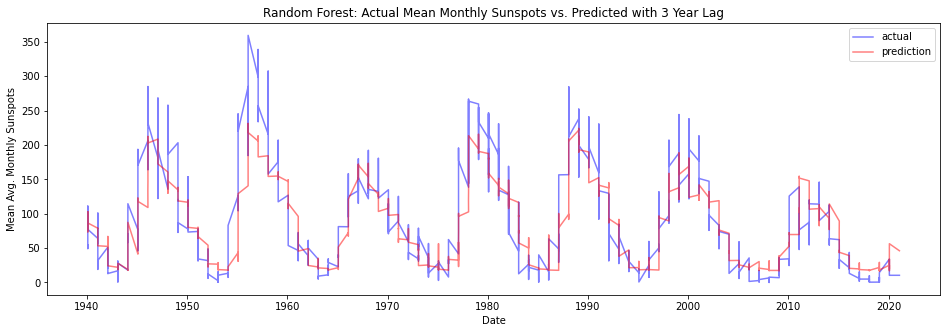

In [58]:
rfr_pred_test_df = rfr_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(rfr_pred_test_df['date'], rfr_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(rfr_pred_test_df['date'], rfr_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Random Forest: Actual Mean Monthly Sunspots vs. Predicted with 3 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Gradient Boosting

In [59]:
from pyspark.ml.regression import GBTRegressor

def gbt_fxn(train, test, max_depth = 5):
  # init model
  gbt = GBTRegressor(featuresCol="features",\
                           labelCol="label",\
                           maxDepth= max_depth,\
                           subsamplingRate=0.8)
  
  # fit model 
  model = gbt.fit(train)
  predictions_gbt_train = model.transform(train)
  predictions_gbt_test = model.transform(test)

  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
  RMSE_gbt_test= evaluator.evaluate(predictions_gbt_test)
  RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)
  return train, test, predictions_gbt_train, predictions_gbt_test , RMSE_gbt_train, RMSE_gbt_test  

In [60]:
gbt_train, gbt_test, gbt_pred_train, gbt_pred_test, gbt_RMSE_train, gbt_RMSE_test = gbt_fxn(train, test, max_depth=5)

gbt_pred_train.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------

In [61]:
gbt_RMSE_test

39.58020518721955

In [62]:
gbt_RMSE_train

23.6867643807057

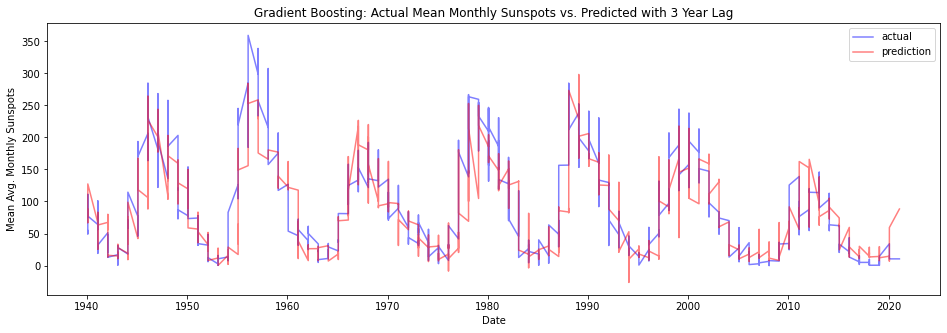

In [63]:
gbt_pred_test_df = gbt_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(gbt_pred_test_df['date'], gbt_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(gbt_pred_test_df['date'], gbt_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Gradient Boosting: Actual Mean Monthly Sunspots vs. Predicted with 3 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Forecast for Best Model

## Time Differencing

Function for first-order differencing -- creates stationary

In [33]:
def first_order_diff(data, input_col, output_col):
    # performs first-order differencing
    lag1_window = window.Window.rowsBetween(-1, 0)
    data = data.withColumn(output_col, data[input_col] -  first(data[input_col]).over(lag1_window))
    return data

# Stop session

In [65]:
spark.stop()